# Regression exploration

There are various versions of regression around. Here we will explore linear, ridge and lasso regression first. I will use sklearn and astroML to illustrate their use and strengths/weaknesses.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astroML.datasets import fetch_sdss_sspp
from astroML.plotting import hist
import seaborn as sns
import pandas as pd
import sys
import cPickle
from sklearn.linear_model import Ridge, Lasso
%matplotlib inline

I quite like to use Seaborn for statistical visualisation but I find the default setting sub-optimal for figures and prefer the 'white' style. I also set the palette to be friendly to colour blind users.

In [20]:
sns.set(style="white")
sns.set_palette('colorblind')

The following two functions are simple convenience functions for saving data to file and getting them back. They can be convenient to have around

In [21]:
def pickle_to_file(data, fname):
    """
    Dump some data to a file using pickle
    """
    try:
        fh = open(fname, 'w')
        cPickle.dump(data, fh)
        fh.close()
    except:
        print "Pickling failed!", sys.exc_info()[0]

def pickle_from_file(fname):
    """
    Retrieve data from file that were saved using cPickle.
    """
    try:
        fh = open(fname, 'r')
        data = cPickle.load(fh)
        fh.close()
    except:
        print "Loading pickled data failed!", sys.exc_info()[0]
        data = None

    return data

## Get stellar photometry from SDSS

The following routine will load stellar data from the SDSS using the `astroML` package. For more details, see [the astroML web-site](http://www.astroml.org/). This will download the data the first time you call the function - this amounts to 37Mb, so do not get it over a mobile link. You can also control where it is downloaded, see the documentation of the `fetch_sdss_sspp` function for more details.

The following call is just to see what is kept within this file.

In [22]:
data = fetch_sdss_sspp()

In [5]:
data.dtype.names

('ra',
 'dec',
 'Ar',
 'upsf',
 'uErr',
 'gpsf',
 'gErr',
 'rpsf',
 'rErr',
 'ipsf',
 'iErr',
 'zpsf',
 'zErr',
 'pmL',
 'pmB',
 'pmErr',
 'mjd',
 'plate',
 'fiber',
 'SNR',
 'FeH',
 'FeHErr',
 'Teff',
 'TeffErr',
 'logg',
 'loggErr',
 'alphFe',
 'alphFeErr',
 'radVel',
 'radVelErr')

## Calculate colours and visualise data

It is always important to have a look at the data before plotting them. Here I use [the Pandas library](http://pandas.pydata.org/) to create a dataframe since this is needed for use with `seaborn`. You can use other approaches if you prefer but I think this is very handy.

The particular plot is a bit slow here.

In [23]:
ug = data['upsf']-data['gpsf']
gr = data['gpsf']-data['rpsf']
ri = data['rpsf']-data['ipsf']
iz = data['ipsf']-data['zpsf']
T = data['Teff']

In [24]:
X = np.vstack((ug, gr, ri, iz, T)).T
M = np.vstack((ug, gr, ri, iz)).T

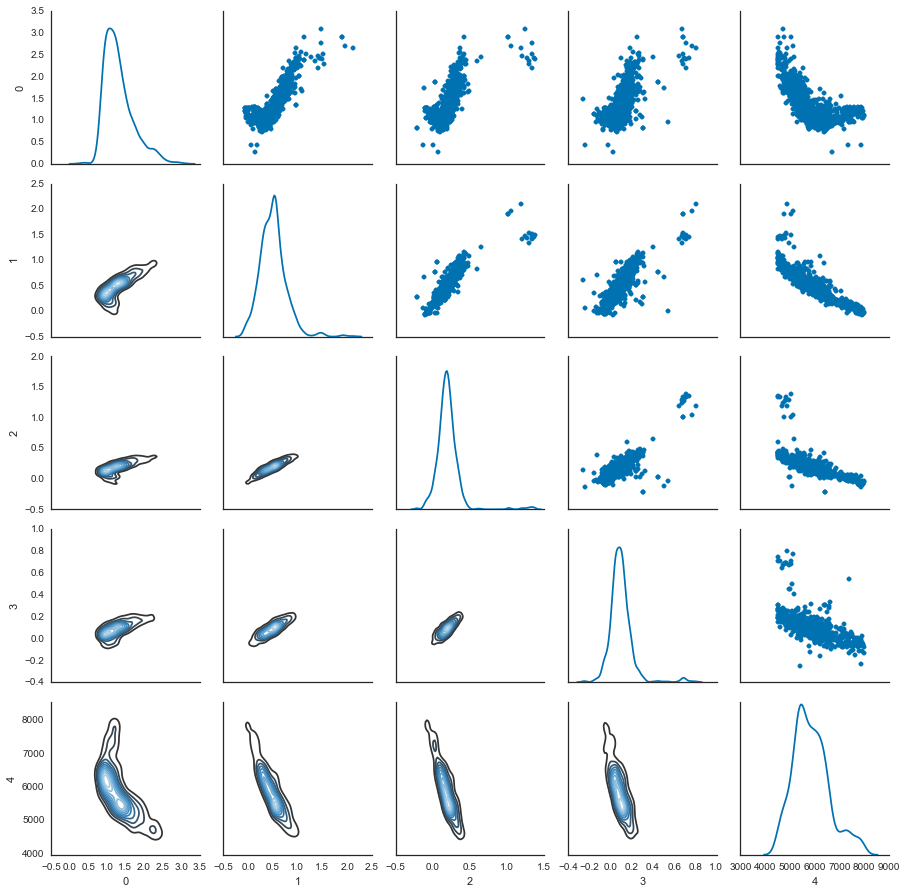

In [25]:
df = pd.DataFrame(X[0:1000, :])
g = sns.PairGrid(df, diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot)

There is plenty of co-linearity in this data. Let me now assume that we can write the effective temperature as a linear combination of data:

$$T = \theta_0 + \theta_1 (u-g) + \theta_2 (g-r) + \theta_3 (r-i) + \theta_5 (i-z) $$

and we want to constrain $\theta$ to create a simple predictor of temperature.

## Regular linear regression

This is the simplest version. I use the `LinearRegression` function in `astroML` because this supports uncertainties - even though I do not use them here!

In [27]:
from astroML.linear_model import LinearRegression

### Create the model

Note that this is independent of the data

In [28]:
model = LinearRegression()

### Fit the model to the data

This is where we introduce the data.

In [29]:
res = model.fit(M, T/1e4)

### Extract best-fit coefficients and calculate the predicted temperature


In [30]:
res.coef_
Tpred = model.predict(M)

We can now plot these results. I am not putting much effort into this! In a real application you would of course look at residuals with respect to all different input quantities.

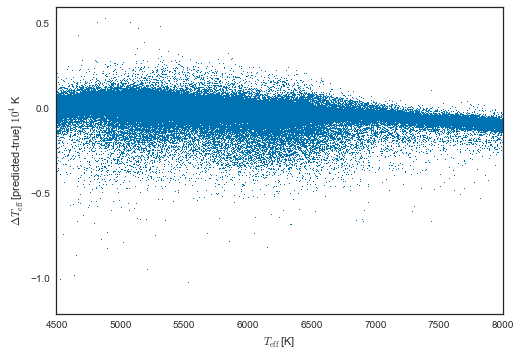

In [51]:
plt.plot(T, (Tpred*1e4-T)/T, ',')
plt.xlabel(r'$T_{\mathrm{eff}}$ [K]')
plt.ylabel(r'$\Delta T_{\mathrm{eff}}$ [predicted-true] $10^4$K')

(-0.5, 0.2)

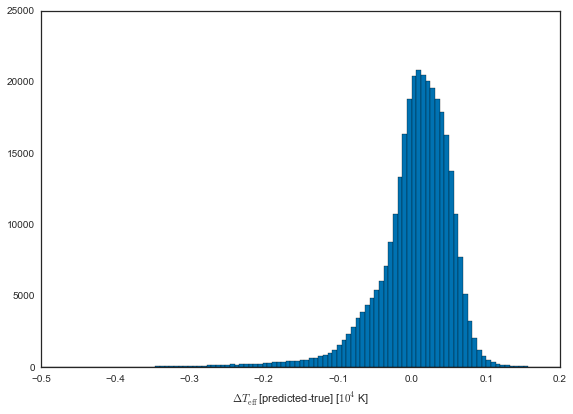

In [50]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.9, 0.9])
hist((Tpred*1e4-T)/T, bins='knuth', ax=ax)
ax.set_xlabel(r'$\Delta T_{\mathrm{eff}}$ [predicted-true] [$10^4$K]')
ax.set_xlim(-0.5, 0.2)

## Ridge regression

The next up is ridge regression. In this case we fit a model in the same way as for linear regression, but we now have a regularisation condition on the coefficients $\theta_i$. In practice it tries to minimize

$$\sum_i (y_i - \sum_j \theta_j x_{ij})^2  + \lambda_i \sum \theta_j^2 $$

so you can see it as a linear regression problem where you also want to ensure that the coefficients don't get too large or too small.

In [82]:
model = Ridge()
res = model.fit(M, T/1e4)

In [83]:
Tpred = model.predict(M)
res.coef_

array([ 0.02504244, -0.26093482, -0.08330986,  0.0345964 ])

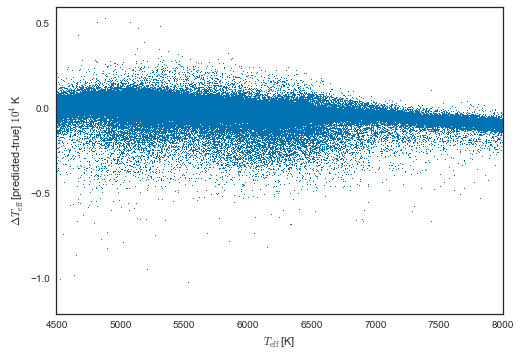

In [84]:
plt.plot(T, (Tpred*1e4-T)/T, ',')
plt.xlabel(r'$T_{\mathrm{eff}}$ [K]')
plt.ylabel(r'$\Delta T_{\mathrm{eff}}$ [predicted-true] $10^4$K')

## LASSO regression

This is very similar to ridge regression, but in this case we now have a regularisation condition on the coefficients $\theta_i$ that sets less important coefficients to zero:

$$\sum_i (y_i - \sum_j \theta_j x_{ij})^2  + \lambda_i \sum |\theta_j| $$

If you are curious why some parameters are set to zero in some cases (as we will see below), take a look at section 6.2 in "An Introduction to Statistical Learning". The practical use of the LASSO is near identical to that of ridge regression:

In [85]:
model = Lasso(alpha=0.001)
res = model.fit(M, T/1e4)

In [86]:
Tpred = model.predict(M)
res.coef_

array([-0.        , -0.23100965, -0.        , -0.        ])

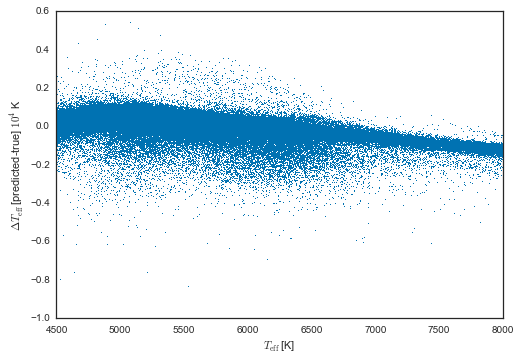

In [88]:
plt.plot(T, (Tpred*1e4-T)/T, ',')
plt.xlabel(r'$T_{\mathrm{eff}}$ [K]')
plt.ylabel(r'$\Delta T_{\mathrm{eff}}$ [predicted-true] $10^4$K')

# Choosing the regularisation parameter

Both LASSO and ridge regression take a separate parameter, $\lambda$, which determines the degree of regularisation. How do you decide on this? You can try trial and error, but the most common way is to divide your data into subsets, and do what is called cross-validation between these sets.

# Stability of estimates

The next step is to try this for very small subsets and store the coefficients. For simplicity I will just shuffle the data and then split into 10 objects. This will help us see how stable the estimates of the different coefficients are with respect to the sample size.

In [52]:
def fit_one_subset(M, T, indices, ridge=False, lasso=False, standard=True, alpha=0.05):
    """
    Fit one subset of the data using one of several methods
    
    Arguments:
    ----------
    M: Design matrix for the model
    T: The independent variable (in the examples here the temperature)
    
    Keywords: 
    ---------
    ridge: Whether to do ridge regression (default=False)
    lasso: Whether to do LASSO regression (default=False)
    standard: Whether to do standard linear regression (default=True)
    alpha: The regularization parameter for LASSO and ridge regression. (default=0.05)
    
    """
    if standard:
        model = LinearRegression(fit_intercept=True)
    elif ridge:
        model = Ridge(alpha=alpha, fit_intercept=True, normalize=True)
    elif lasso:
        model = Lasso(alpha=alpha, fit_intercept=True, normalize=True)
    
    res = model.fit(M[indices, :], T[indices]/1e4)
    
    return res.coef_

def run_many_subsets(M, T, N_per=10, N_sets=1000, ridge=False, lasso=False, standard=True, alpha=0.05):
    """
    Fit N_sets of N_per objects.
    
    Arguments:
    ----------
    M: Design matrix for the model
    T: The independent variable (in the examples here the temperature)
    
    Keywords: 
    ---------
    N_per: The number of objects per subset.
    N_sets: The number of subsets to create.
    ridge: Whether to do ridge regression (default=False)
    lasso: Whether to do LASSO regression (default=False)
    standard: Whether to do standard linear regression (default=True)    
    alpha: The regularization parameter for LASSO and ridge regression. (default=0.05)
    """
    
    if (N_per*N_sets > len(T)):
        print "It is not possible to have this combination of N_per and N_sets"
        return None
    
    # This is the index array
    inds = np.arange(len(T))
    # Now shuffle it.
    np.random.shuffle(inds)
    
    subset_coefs = np.zeros((N_sets, 5))
    
    for i in range(N_sets):
        subset = inds[i*N_per:(i+1)*N_per]
        
        subset_coefs[i, :] = fit_one_subset(M, T, subset, ridge=ridge, lasso=lasso, standard=standard, alpha=alpha)
        
    return subset_coefs

In [53]:
coefs6 = run_many_subsets(M, T, N_per=6)
coefs100 = run_many_subsets(M, T, N_per=100)

In [54]:
coefs6[0, :]

array([ 1.04197511, -0.59304107, -0.25877428,  1.75594504, -0.24152374])

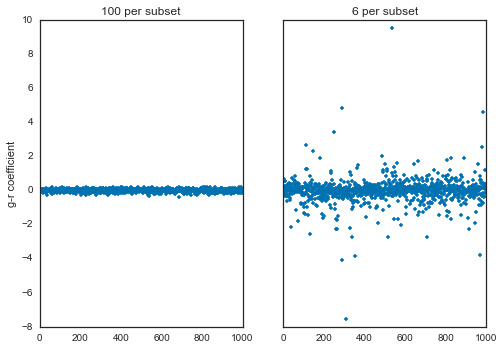

In [55]:
xaxis = np.arange(coefs100.shape[0])
fig, axes = plt.subplots(1, 2, sharey=True)
axes[0].plot(xaxis, coefs100[:, 2]-np.median(coefs100[:, 2]), '.')
axes[0].set_title('100 per subset')
axes[0].set_ylabel('g-r coefficient')
axes[1].plot(xaxis, coefs6[:, 2]-np.median(coefs6[:, 2]), '.')
axes[1].set_title('6 per subset')
plt.savefig('g-r-coeff-variation.pdf', format='pdf')

What this tells us, is that prediction of the coefficient is very unstable when we have a small number of data points. In statistics lingo the coefficient has large *variance*.

# Regularising the situation

Ridge regression and the lasso (and other techniques), allow one to run the same fits, but with some regularisation (constraints on the $\theta_i$). This helps obtain better values for the parameters, but at the cost of a slight bias in their values.

I save the output below, but in fact it is so quick it does have to be.

In [60]:
def run_many_lambdas(M, T, ridge=True, lasso=False):
    """
    Fit N_sets of N_per objects.
    
    This is near identical to 
    """
    
    # I want repeatability 
    np.random.seed(0)
    
    # This is the index array
    inds = np.arange(len(T))
    # Now shuffle it.
    np.random.shuffle(inds)

    n_alpha = 100
    alphas = np.logspace(-4, 2, n_alpha)

    # Get 20 stars out.
    subset = inds[0:20]
    subset_coefs = np.zeros((n_alpha, 4))
    
   
    for i in range(n_alpha):
                
        subset_coefs[i, :] = fit_one_subset(M, T, subset, ridge=ridge, lasso=lasso,\
                                            standard=False, alpha=alphas[i])
        
    return alphas, subset_coefs, subset

## Ridge regression

In [57]:
a_ridge, coefs_ridge, subset = run_many_lambdas(M, T, ridge=True)

In [58]:
pickle_to_file((M[subset, :], T[subset]), "T-vs-colour-regression.pkl")

Next, let us plot the coefficients as a function of the regularisation parameter. In this case, remember, we have 10 objects per subset because that is the default.

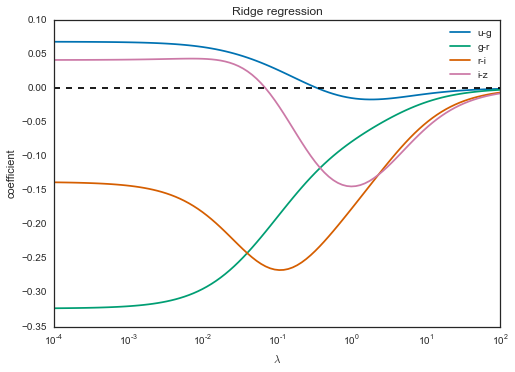

In [61]:
plt.semilogx(a_ridge, coefs_ridge[:, 0], label='u-g')
plt.semilogx(a_ridge, coefs_ridge[:, 1], label='g-r')
plt.semilogx(a_ridge, coefs_ridge[:, 2], label='r-i')
plt.semilogx(a_ridge, coefs_ridge[:, 3], label='i-z')
plt.plot([1e-4, 1e2], [0, 0], 'k--')
plt.legend()
plt.xlabel(r'$\lambda$')
plt.ylabel('coefficient')
plt.title('Ridge regression')
plt.savefig('ridge-coeffs.pdf', format='pdf')

## LASSO regression

In [ ]:
a_lasso, coefs_lasso = run_many_lambdas(M, T, ridge=False, lasso=True)

In [ ]:
plt.semilogx(a_lasso, coefs_lasso[:, 0], label='u-g')
plt.semilogx(a_lasso, coefs_lasso[:, 1], label='g-r')
plt.semilogx(a_lasso, coefs_lasso[:, 2], label='r-i')
plt.semilogx(a_lasso, coefs_lasso[:, 3], label='i-z')
plt.plot([1e-4, 1e2], [0, 0], 'k--')
plt.legend()
plt.xlabel(r'$\lambda$')
plt.ylabel('coefficient')
plt.title('LASSO regression')
plt.savefig('LASSO-coeffs.pdf', format='pdf')

In [ ]:
data = (M[subset, :], T[:])
pickle_to_file(data, 'T-vs-colour-regression.pkl')